In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tqdm pyarrow

Tariff dataset uses numeric reporter codes, but your trade dataset uses ISO3 country codes
pycountry-convert mapping from M49 → ISO3

In [ ]:
!pip install pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 67.3 MB/s eta 0:00:00


Main run for the Code

In [ ]:
tariff = pd.read_csv(TARIFF_CSV_PATH)
print(tariff.columns.tolist())


['Selected Nomen', 'Native Nomen', 'Reporter', 'Reporter Name', 'Product', 'Product Name', 'Partner', 'Partner Name', 'Tariff Year', 'Trade Year', 'Trade Source', 'DutyType', 'Simple Average', 'Weighted Average', 'Standard Deviation', 'Minimum Rate', 'Maximum Rate', 'Nbr of Total Lines', 'Nbr of DomesticPeaks', 'Nbr of InternationalPeaks', 'Imports Value in 1000 USD', 'Binding Coverage']


Trade rows: 2712073
Tariff rows: 111684
Tariff shocks detected: 766


100%|██████████| 766/766 [04:17<00:00,  2.98it/s]

Valid partner shifts computed: 351
  reporter  avg_shift  shocks  avg_tariff
1      CAN   0.541667       2    6.649263
2      CHN   0.402778      30    8.370957
3      IND   0.368413     200    9.880616
0      BRA   0.365193     105   11.704296
5      ZAF   0.329670      13    9.123765


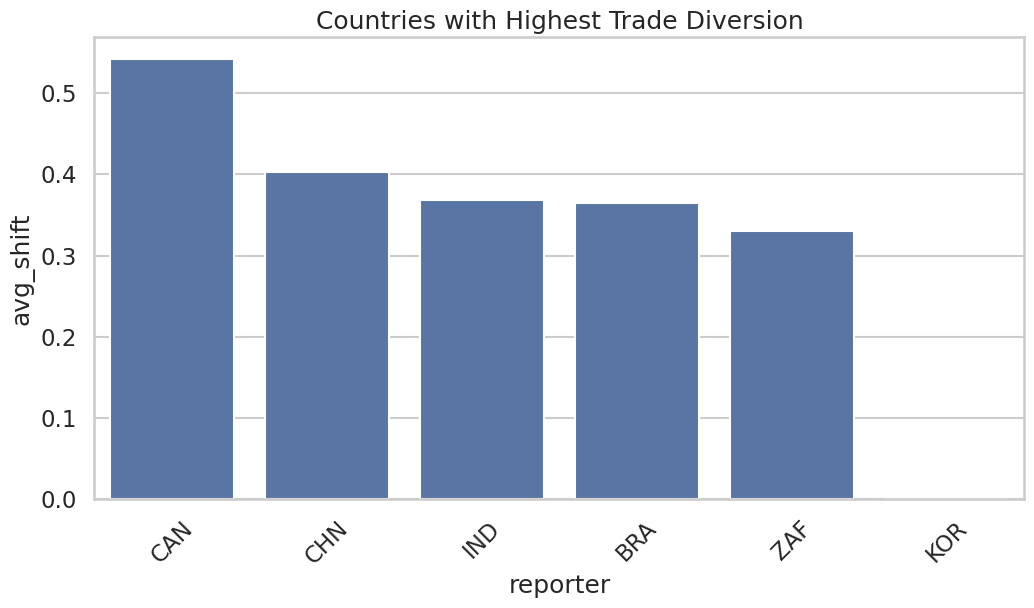

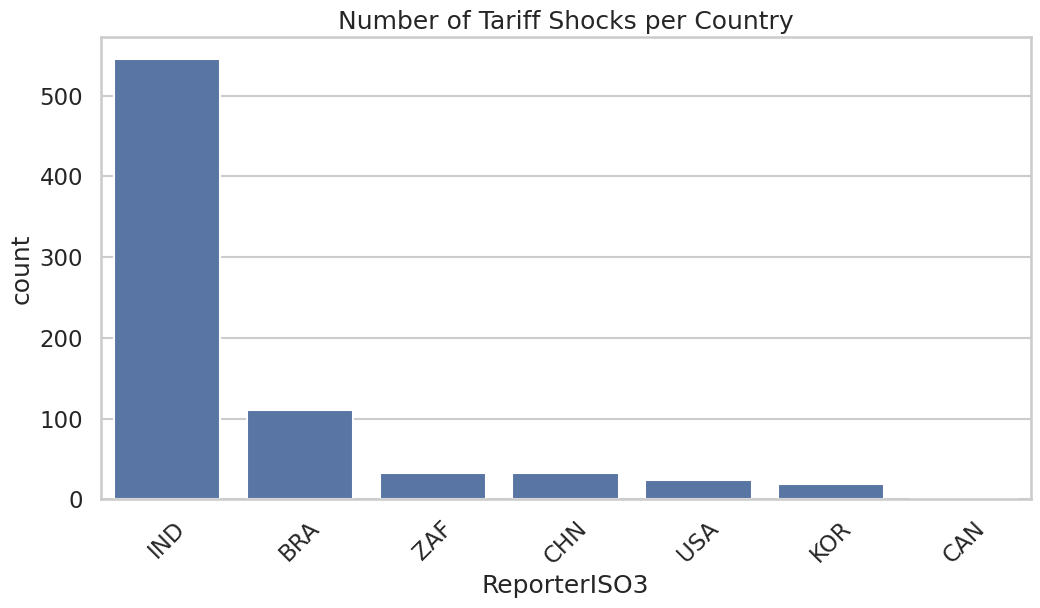

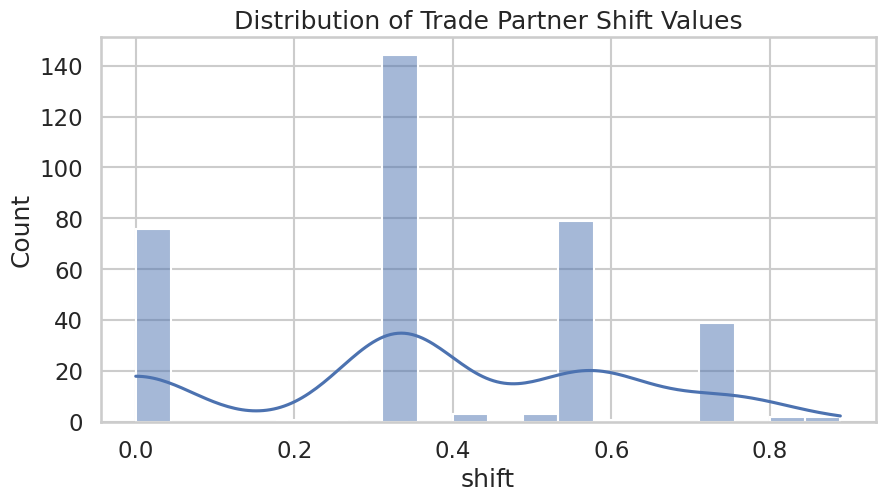

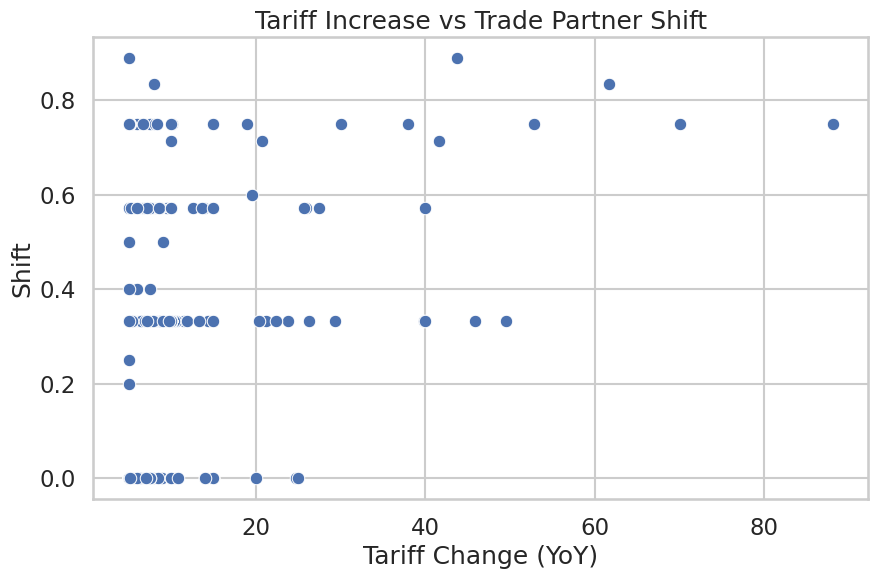

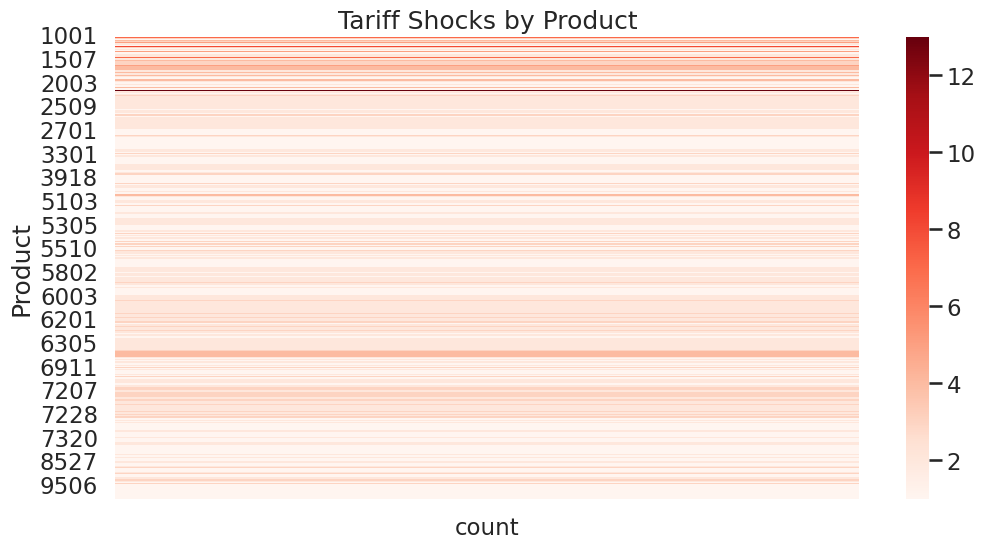

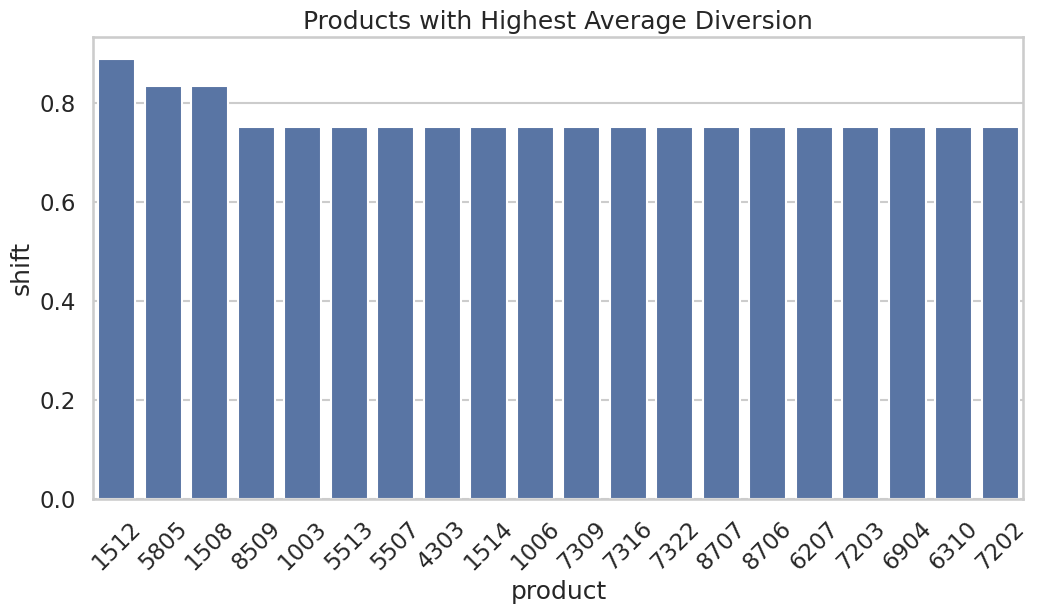

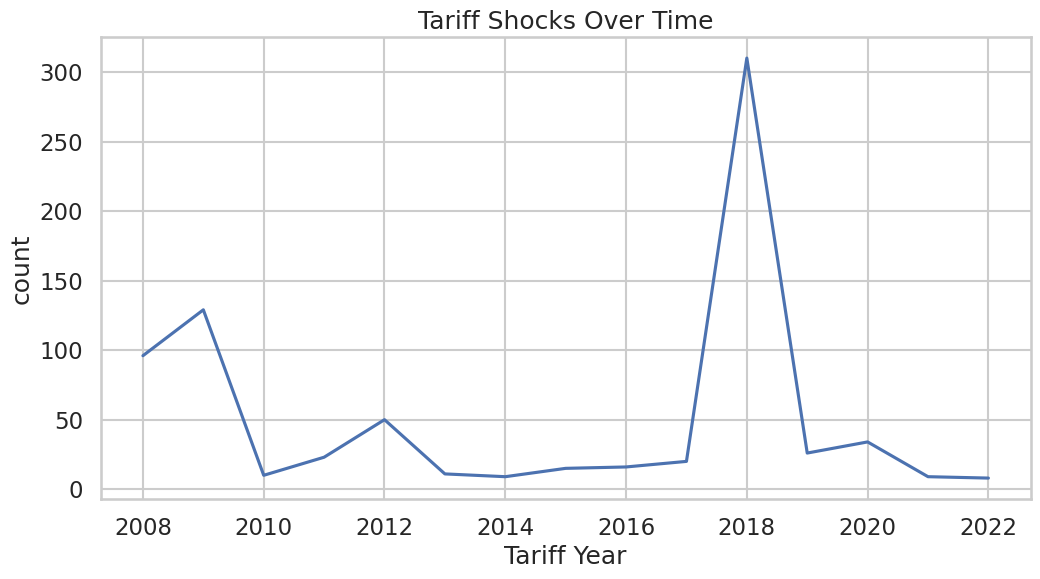

In [ ]:
# GLOBAL TRADE DIVERSION ANALYSIS

import pandas as pd
import numpy as np
import pycountry
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import lru_cache

sns.set(style="whitegrid", context="talk")

# Load files and setup
TRADE_CSV_PATH  = "/content/drive/MyDrive/Big Data Final Project/2 Cleaned data - Hrishik/merged_trade_cleaned.csv"
TARIFF_CSV_PATH = "/content/drive/MyDrive/Big Data Final Project/2 Cleaned data - Hrishik/merged_tariff_cleaned.csv"

CONFIG = {
    "trade_reporter": "ReporterISO3",
    "trade_partner": "PartnerISO3",
    "trade_product": "ProductCode",
    "trade_year": "Year",
    "trade_value": "TradeValue in 1000 USD",
    "trade_flow": "TradeFlowName",
    "trade_flow_import_label": "Import",

    "tariff_reporter": "ReporterISO3",
    "tariff_partner": "PartnerISO3",
    "tariff_product": "Product",
    "tariff_year": "Tariff Year",
    "tariff_value": "Simple Average"
}

MIN_PRE_TRADE = 50
MIN_TARIFF_INCREASE = 5
PRE_WINDOW = 1
POST_WINDOW = 1
TOP_K = 5


# Mapping check: UN M49 → ISO3 COUNTRY CODE MAPPING

def m49_to_iso3(code):
    """Convert numeric UN M49 codes to ISO-3 country codes."""
    try:
        return pycountry.countries.get(numeric=str(code).zfill(3)).alpha_3
    except:
        return None


def load_trade():
    df = pd.read_csv(TRADE_CSV_PATH)

    df = df[df[CONFIG["trade_flow"]] == CONFIG["trade_flow_import_label"]]

    df[CONFIG["trade_year"]] = df[CONFIG["trade_year"]].astype(int)
    df[CONFIG["trade_value"]] = df[CONFIG["trade_value"]].astype(float)

    df["ProductCode"] = df["ProductCode"].astype(str).str.zfill(4)

    return df


def load_tariff():
    df = pd.read_csv(TARIFF_CSV_PATH)

    df["ReporterISO3"] = df["Reporter"].apply(m49_to_iso3)
    df["PartnerISO3"]  = df["Partner"].apply(m49_to_iso3)

    df[CONFIG["tariff_year"]] = df[CONFIG["tariff_year"]].astype(int)
    df[CONFIG["tariff_value"]] = df[CONFIG["tariff_value"]].astype(float)

    df["Product"] = df["Product"].astype(str).str.zfill(4)

    return df



# Aggregation of Trade and Tariff

def aggregate_trade(df):
    return df.groupby([
        CONFIG["trade_reporter"],
        CONFIG["trade_partner"],
        CONFIG["trade_product"],
        CONFIG["trade_year"]
    ], as_index=False)[CONFIG["trade_value"]].sum()


def aggregate_tariff(df):
    return df.groupby([
        CONFIG["tariff_reporter"],
        CONFIG["tariff_product"],
        CONFIG["tariff_year"]
    ], as_index=False)[CONFIG["tariff_value"]].mean()


# DETECT TARIFF SHOCKS

def detect_shocks(tariff):
    tariff = tariff.sort_values([
        CONFIG["tariff_reporter"],
        CONFIG["tariff_product"],
        CONFIG["tariff_year"]
    ])

    tariff["prev"] = tariff.groupby(
        [CONFIG["tariff_reporter"], CONFIG["tariff_product"]]
    )[CONFIG["tariff_value"]].shift(1)

    tariff["change"] = tariff[CONFIG["tariff_value"]] - tariff["prev"]

    shocks = tariff[tariff["change"] >= MIN_TARIFF_INCREASE].copy()
    shocks["shock_id"] = range(len(shocks))

    return shocks


# CACHED PARTNER DISTRIBUTION

@lru_cache(None)
def get_dist(reporter, product, years_tuple):
    yrs = list(years_tuple)

    df = trade_agg[
        (trade_agg[CONFIG["trade_reporter"]] == reporter) &
        (trade_agg[CONFIG["trade_product"]] == product) &
        (trade_agg[CONFIG["trade_year"]].isin(yrs))
    ]

    if df.empty:
        return None

    total = df[CONFIG["trade_value"]].sum()
    if total < MIN_PRE_TRADE:
        return None

    dist = df.groupby(CONFIG["trade_partner"], as_index=False)[CONFIG["trade_value"]].sum()
    dist["share"] = dist[CONFIG["trade_value"]] / dist[CONFIG["trade_value"]].sum()

    return dist.sort_values("share", ascending=False)


# PARTNER SHIFTS

def compute_shifts(shocks):
    results = []
    rows = shocks.to_dict("records")

    for s in tqdm(rows):
        reporter = s[CONFIG["tariff_reporter"]]
        product  = s[CONFIG["tariff_product"]]
        year     = s[CONFIG["tariff_year"]]

        pre  = get_dist(reporter, product, tuple(range(year - PRE_WINDOW, year)))
        post = get_dist(reporter, product, tuple(range(year + 1, year + 1 + POST_WINDOW)))

        if pre is None or post is None:
            continue

        pre_top  = set(pre.head(TOP_K)[CONFIG["trade_partner"]])
        post_top = set(post.head(TOP_K)[CONFIG["trade_partner"]])

        union = pre_top | post_top
        inter = pre_top & post_top

        shift = 1 - len(inter)/len(union) if union else np.nan

        results.append({
            "reporter": reporter,
            "product": product,
            "year": year,
            "shift": shift,
            "tariff_change": s["change"]
        })

    return pd.DataFrame(results)


# SUMMARY TABLE

def summarize(df):
    return df.groupby("reporter", as_index=False).agg(
        avg_shift=("shift","mean"),
        shocks=("shift","count"),
        avg_tariff=("tariff_change","mean")
    ).sort_values("avg_shift", ascending=False)

trade = load_trade()
tariff = load_tariff()

trade_agg  = aggregate_trade(trade)
tariff_agg = aggregate_tariff(tariff)

print("Trade rows:", len(trade_agg))
print("Tariff rows:", len(tariff_agg))

shocks = detect_shocks(tariff_agg)
print("Tariff shocks detected:", len(shocks))

# Only products affected by shocks
trade_agg = trade_agg[trade_agg[CONFIG["trade_product"]].isin(shocks[CONFIG["tariff_product"]])]

shifts = compute_shifts(shocks)
print("Valid partner shifts computed:", len(shifts))

summary = summarize(shifts)
print(summary.head())

# PLOT 1: Top countries by avg shift
plt.figure(figsize=(12,6))
sns.barplot(data=summary.head(15), x="reporter", y="avg_shift")
plt.xticks(rotation=45)
plt.title("Countries with Highest Trade Diversion")
plt.show()

# PLOT 2: Number of tariff shocks per country
plt.figure(figsize=(12,6))
sns.barplot(
    data=shocks.groupby("ReporterISO3").size().reset_index(name="count").sort_values("count", ascending=False),
    x="ReporterISO3", y="count"
)
plt.xticks(rotation=45)
plt.title("Number of Tariff Shocks per Country")
plt.show()

# PLOT 3: Distribution of shift magnitudes
plt.figure(figsize=(10,5))
sns.histplot(shifts["shift"], bins=20, kde=True)
plt.title("Distribution of Trade Partner Shift Values")
plt.show()

# PLOT 4: Tariff change vs shift
plt.figure(figsize=(10,6))
sns.scatterplot(data=shifts, x="tariff_change", y="shift")
plt.title("Tariff Increase vs Trade Partner Shift")
plt.xlabel("Tariff Change (YoY)")
plt.ylabel("Shift")
plt.show()

# PLOT 5: Shocks by product (heatmap)
product_counts = shocks.groupby("Product").size().reset_index(name="count")
plt.figure(figsize=(12,6))
sns.heatmap(product_counts.pivot_table(values="count", index="Product"), cmap="Reds")
plt.title("Tariff Shocks by Product")
plt.show()

# PLOT 6: Shifts by product
prod_shift = shifts.groupby("product")["shift"].mean().reset_index().sort_values("shift", ascending=False).head(20)
plt.figure(figsize=(12,6))
sns.barplot(data=prod_shift, x="product", y="shift")
plt.xticks(rotation=45)
plt.title("Products with Highest Average Diversion")
plt.show()

# PLOT 7: Shocks over time
yearly = shocks.groupby(CONFIG["tariff_year"]).size().reset_index(name="count")
plt.figure(figsize=(12,6))
sns.lineplot(data=yearly, x=CONFIG["tariff_year"], y="count")
plt.title("Tariff Shocks Over Time")
plt.show()
